# SEP532 - 인공지능 이론과 실제 (2022 Spring)
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

# 5. Overfitting And How To Fight It

**Oveffiting** is that the accuracy of model on the validation data would peak after training for a number of epochs, and would then stagnate or start decreasing.

<img src="https://github.com/keai-kaist/SEP532/blob/master/Week1/imgs/overfit_ex.png?raw=true" align="center" width="700" />


Although it's often possible to achieve high accuracy on the training set, what we really want is to develop models that generalize well to a testing set (or data they haven't seen before).

Hence, learning how to deal with overfitting is important. To prevent overfitting, the best solution is to use more training data. If it is difficult to increase amount of the data, there are several techniques such as **weight decay (regularization), dropout, and early stopping.** 

In [1]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
from matplotlib import pyplot as plt

# !pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

2.7.0


## The Higgs Dataset

To check the overfitting exampel, we use the Higgs Dataset, which contains 11,000,000 examples, each with 28 features, and a binary class label.

In [2]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [3]:
FEATURES = 28

#### IMDB Dataset 

```python
NUM_WORDS = 1000

(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # results[i]의 특정 인덱스만 1로 설정합니다
    return results


train_data = multi_hot_sequences(train_data, dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)
```

### Data pipeline

To read the csv records directly from a gzip file with no intermediate decompression step, we use the `tf.data.experimental.CsvDataset` class

In [4]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [5]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

For efficient training, we make a new `Dataset` that takes batches of 10000-examples, instead of repacking each row indivisually. 

In [6]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


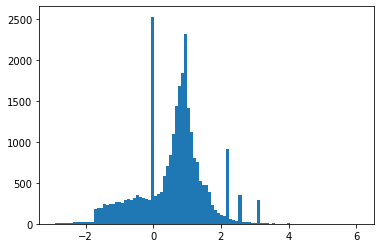

In [7]:
for features,label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

Use just the first 1000 samples for validation and the next 10000 for training. The `Dataset.skip` and `Dataset.take` methods make this easy. At the same time, use the `Dataset.cache` method to ensure that the loader doesn't need to re-read the data from the file on each epoch. 

In [8]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [9]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

These datasets return individual examples. Use the `.batch` method to create batches of an appropriate size for training. Before batching also remember to `.shuffle` and `.repeat` the training set.

In [10]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

### Training procedure

Many models train better if you gradually reduce the learning rate during training. Use optimizers.schedules to reduce the learning rate over time:

In [11]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a `schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

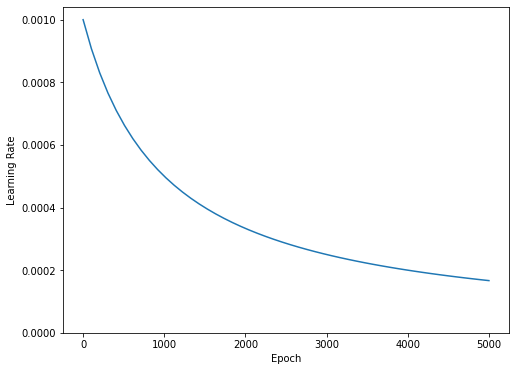

In [12]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

**Early stopping:** `callbacks.EarlyStopping` is to avoid long and unnecessary training times.

In [13]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200)
    ]

In [14]:
def compile_and_fit(model, name, optimizer=None, max_epochs=2000):
  if optimizer is None:
    optimizer = get_optimizer()
    
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Tiny model

In [15]:
tiny_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(1)
])

size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5015,  binary_crossentropy:0.8389,  loss:0.8389,  val_accuracy:0.4950,  val_binary_crossentropy:0.7696,  val_loss:0.7696,  
....................................................................................................
Epoch: 100, accuracy:0.5994,  binary_crossentropy:0.6262,  loss:0.6262,  val_accuracy:0.5710,  val_binary_crossentropy:0.6297,  val_loss:0.6297,  
............................................................

(0.5, 0.7)

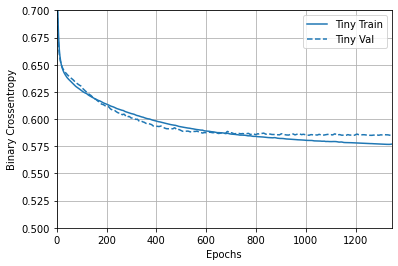

In [16]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model

2 hidden layers with 16 units each:

In [ ]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

### Medium model

3 hidden layers with 64 units each:

In [ ]:
medium_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dense(64, activation='elu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

### Large model 

Let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [ ]:
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

### Plot the training and validation losses



In [ ]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the "Tiny" model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the "large" model that you need to switch the plot to a log-scale to really see what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.

- It's normal for there to be a small difference.
- If both metrics are moving in the same direction, everything is fine.
- If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
- If the validation metric is going in the wrong direction, the model is clearly overfitting.

## Strategies to prevent Overfitting

We use a `"Tiny" model` above as a baseline for comparison.

In [ ]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Add weight regularization 

Common way to mitigate overfitting is to **put constraints on the complexity of a network by forcing its weights only to take small values**, which **makes the distribution of weight values more "regular".** This is called **"_weight regularization_"**, and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

 - [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

 - [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.
 
 
<img src="https://github.com/keai-kaist/SEP532/blob/master/Week1/imgs/reg_eq.png?raw=true" align="center" width="700" />

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [ ]:
l2_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    tf.keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(512, activation='elu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

As you can see, the `"L2"` regularized model is now much more competitive with the the "Tiny" model. This `"L2"` model is also much more resistant to overfitting than the `"Large"` model it was based on despite having the same number of parameters.

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

<img src="https://github.com/keai-kaist/SEP532/blob/master/Week1/imgs/dropout.png?raw=true" align="center" width="600" />

In `tf.keras` you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our network to see how well they do at reducing overfitting:

In [ ]:
dropout_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")


In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

### Combine L2 + dropout

In [ ]:
combined_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

### Other strategies?

- Data-augmentation
- Batch normalization